# The Amplitude Estimation Benchmark Test Case

In the **01_AmplitudeEstimationKernel.ipynb** notebook the **AE kernel** was explained. In this notebook the associated benchmark test case (**BTC**) is presented. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1.  Description of the problem

The benchmark problem is the computation of the integral of a function $f(x)$ in a closed interval $[a,b] \subset \mathbf{R}$:

$$I = \int_a^bf(x)dx$$

In particular we propose to use $f(x) = \sin x$, whose integral is very well known:

$$I = \int_a^{b}\sin(x)dx = -\cos x |_a^b = \cos(a)-\cos(b)$$

Additionally, 2 different integration intervals will be used:

1. $[0, \frac{3\pi}{8}]$ : $I = \int_0^{\frac{3\pi}{8}}\sin(x)dx = 0.6173165676349102$
2. $[\pi, \frac{5\pi}{4}]$ : $I = \int_{\pi}^{\frac{5\pi}{4}}\sin(x)dx = -0.2928932188134523$


In [2]:
def sin_integral(a,b):
    return np.cos(a)-np.cos(b)

In [3]:
start = [0.0, 3.0*np.pi/4.0, np.pi]
end = [3.0*np.pi/8.0, 9.0*np.pi/8.0, 5.0*np.pi/4.0]

#### $1^{st}$  Domain: $[0, \frac{3\pi}{8}]$ 

In this domain the function is strictly positive defined.

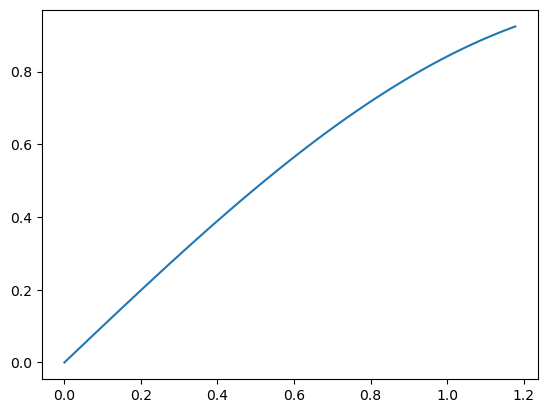

In [4]:
a = start[0]
b = end[0]
domain = np.linspace(a,b, 100)
plt.plot(domain, np.sin(domain))
#plt.show()

In [5]:
print('Integral in first domain: {}'.format(sin_integral(a,b)))

Integral in first domain: 0.6173165676349102


In [ ]:
a = start[1]
b = end[1]
domain = np.linspace(a,b, 100)
plt.plot(domain, np.sin(domain))

In [ ]:
print('Integral in second domain: {}'.format(sin_integral(a,b)))

#### $2^{nd}$ Domain: $[\pi, \frac{5\pi}{4}]$

In this domain, the function is not strictly positively defined and the integral is negative!

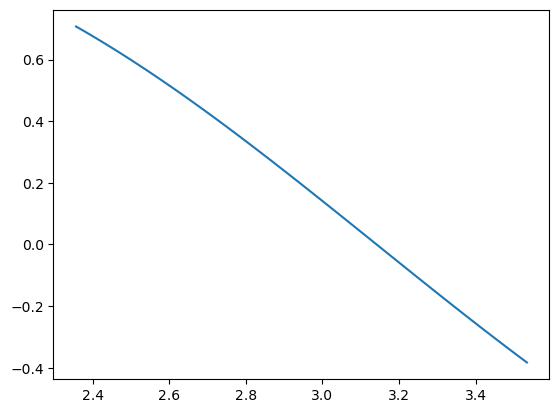

In [6]:
a = start[1]
b = end[1]
domain = np.linspace(a,b, 100)
plt.plot(domain, np.sin(domain))

In [7]:
print('Integral in thrid domain: {}'.format(sin_integral(a,b)))

Integral in thrid domain: 0.2167727513247394


## 2. BTC Workflow

Now we present the complete Workflow for the **BTC** for the **AE kernel**.

### 2.1. Domain Discretization

The first thing to do for computing the integral in a computer is the discretization of the domain. In the benchmark we always discretize the domain in $2^n$ intervals, with $n \in \mathbf{N}$:

$$\{[x_0, x_1], [x_1, x_2], ..., [x_{2^n-1}, x_{2^n}]\}$$ 

Where

1. $x_{i+1} < x_{i}$
2. $a = x_0$
3. $b = x_{2^n}$

In [8]:
#First integration domain
a = start[0]
b = end[0]
#For fix the number of discretization intervals
n=4
domain_x = np.linspace(a, b, 2**n+1)

### 2.2. Function discretization

Now using the domain discretization we need to discretized $f(x)$. In our procedure following arrays should be constructed:

1. $\Delta x_i = x_{i+1} - x_{i} = \frac{b-a}{2^n}$
2. $f_{x_i} = \frac{f(x_{i+1}) + f(x_{i})}{2}$
3. $f_{x_i} \Delta x_i = f_{x_i} \frac{b-a}{2^n}$

Using these computed arrays the desired integral can be approximated by Riemann sum:

$$S_{[a,b]} = \sum_{i=0}^{2^n-1} f_{x_i} \Delta x_i$$

When $\Delta x_i \rightarrow 0$ then $I =\int_a^{b}\sin(x)dx \approx S_{[a,b]}$.

Using $\Delta x_i  = \frac{b-a}{2^n}$ then we can write down:


$$S_{[a,b]} = \sum_{i=0}^{2^n-1} f_{x_i} \frac{b-a}{2^n} = \frac{b-a}{2^n} \sum_{i=0}^{2^n-1} f_{x_i}$$

In [9]:
#The selected fucntion
f = np.sin

#Discretization of the selected function
f_x = []
x_ = []
for i in range(1, len(domain_x)):
    step_f = (f(domain_x[i]) + f(domain_x[i-1]))/2.0
    #print(i)
    f_x.append(step_f)
    x_.append((domain_x[i] + domain_x[i-1])/2.0)
f_x = np.array(f_x)
x_ = np.array(x_)


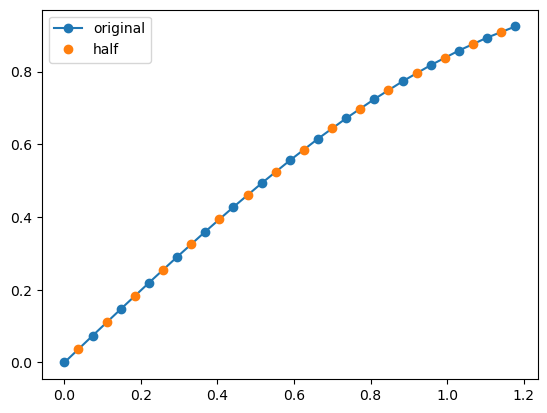

In [10]:
plt.plot(domain_x, f(domain_x), '-o')
plt.plot(x_, f_x, 'o')
plt.legend(['original', 'half'])

In [11]:
Riemann = (np.sum(f_x)*(b-a))/2**n
print("Riemann sum integral: {}".format(Riemann))
print('Exact Integral in first domain: {}'.format(sin_integral(a,b)))

Riemann sum integral: 0.6170376421171327
Exact Integral in first domain: 0.6173165676349102


### 2.3. Array Normalisation

The idea is to encode the $2^n$ discretized array $f_{x_i}$ in a $n+1$ qubit circuit. Before doing that we are going to normalise the array in the following way:


$$f^{norm}_{x_i} = \frac{f_{x_i}}{\max(|f_{x_i}|)}$$

If $\max{|f_{x_i}|} \leq 1$ then this step can be omitted.

Now the computed integral will be

\begin{equation}
S_{[a,b]} = \frac{b-a}{2^n} \sum_{i=0}^{2^n-1} f_{x_i} = \frac{b-a}{2^n} \sum_{i=0}^{2^n-1}  \max(|f_{x_i}|) f^{norm}_{x_i} =\frac{\max(|f_{x_i}|)(b-a)}{2^n} \sum_{i=0}^{2^n-1} f^{norm}_{x_i}
\end{equation}

In [12]:
normalization = np.max(np.abs(f_x))
print("Normalization constant: {}".format(normalization))
#normalization = 1.0
f_norm_x = f_x/normalization
Riemann = normalization * np.sum(f_norm_x)*(b-a)/2**n
#Now we need to be aware of the normalization constant when computing Rieman sum
print("Riemman sum integral: {}".format(Riemann))
print('Exact Integral in first domain: {}'.format(sin_integral(a,b)))

Normalization constant: 0.9085519168534011
Riemman sum integral: 0.6170376421171329
Exact Integral in first domain: 0.6173165676349102


### 2.4. Encoding function in a quantum circuit.

The next step is to codify $f^{norm}_{x_i}$ array in a quantum circuit. The following procedure must be used:

1. Initialize a quantum register with at least $n+1$ qubits, where $n$ must be equal to the $n$ used to define the $2^n$ discretization intervals $$|0\rangle\otimes|0\rangle_n \tag{1}$$
2. Apply the uniform distribution over the first $n$ qubits: $$\big(I \otimes H^{\otimes n}\big)\big(|0\rangle \otimes|0\rangle_{n}\big) = |0\rangle \otimes H^{\otimes n}|0\rangle_{n}=
\frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^{n}-1}|0\rangle \otimes|i\rangle_{n} \tag{2}$$
3. Creates an operator $\mathbf{U}_f$ for encoding the $f\_norm_{x_i}$. This operator acts in the following way: $$\mathbf{U}_f \left(|0\rangle \otimes |i\rangle_n\right) =  \big(f^{norm}_{x_i}|0\rangle +  \beta_i |1\rangle \big) \otimes |i\rangle_n  \tag{3}$$ In the equation $(3)$ the coefficient of $|1\rangle$ it is not important for us the only important coefficient it is the $|0\rangle$ one.
4. Apply the $\mathbf{U}_f$ operator over $n+1$ qubits: $$\mathbf{U}_f\left(I\otimes H^{\otimes n}\right)|0\rangle\otimes|0\rangle_{n} \tag{4}$$
5. Applying equation $(2)$ and  $(3)$ on $(4)$: $$\mathbf{U}_f\left(I\otimes H^{\otimes n} \right)|0\rangle\otimes|0\rangle_{n} = \mathbf{U}_f \left(\frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^{n}-1} |0\rangle\otimes|i\rangle_{n}\right) = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^{n}-1} \mathbf{U}_f \left(|0\rangle\otimes|i\rangle_{n}\right) = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^{n}-1} |i\rangle_{n} \otimes \left(f^{norm}_{x_i}|0\rangle + \beta_i|1\rangle \right) \tag{5}$$
6. Finally the uniform distribution will be applied over the first n qubits again: $$|\Psi \rangle = \left(I\otimes H^{\otimes n} \right)\mathbf{U}_f\left(I\otimes H^{\otimes n} \right)|0\rangle\otimes|0\rangle_{n} \tag{6}$$
7. So applying $(5)$ on $(6)$: $$|\Psi \rangle = \left(I\otimes H^{\otimes n} \right)\mathbf{U}_f\left(I\otimes H^{\otimes n} \right)|0\rangle\otimes|0\rangle_{n} = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^{n}-1} H^{\otimes n}|i\rangle_{n} \otimes \left(f^{norm}_{x_i}|0\rangle + \beta_i|1\rangle \right) \tag{7}$$
8. We are interested only in $|0\rangle \otimes |i\rangle_{n}$ so we don't need to take into account other terms, so $(7)$ can be expressed as: $$|\Psi \rangle = \left(I\otimes H^{\otimes n} \right)\mathbf{U}_f\left(I\otimes H^{\otimes n} \right)|0\rangle\otimes|0\rangle_{n} = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^{n}-1} f^{norm}_{x_i}|0\rangle \otimes H^{\otimes n}|i\rangle_{n}   + \cdots \tag{8}$$
9. It is known that: $$H^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n}\sum_{k=0}^{2^n} (-1)^{jk} |j\rangle_n  {}_{n} \langle k|$$.
10. So:$$H^{\otimes n} |i\rangle_n = \frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n}\sum_{k=0}^{2^n} (-1)^{jk} |j\rangle_n  {}_{n} \langle k|i\rangle_n = \frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n} (-1)^{ji} |j\rangle = \frac{1}{\sqrt{2^n}} |0\rangle_n + \frac{1}{\sqrt{2^n}} \sum_{j=1}^{2^n} (-1)^{ji} |j\rangle \tag{9}$$
11. Finally applying $(9)$ in $(8)$ and taking only into account the $|0\rangle \otimes |0\rangle_{n}$   $$|\Psi \rangle = \left(I\otimes H^{\otimes n} \right)\mathbf{U}_f\left(I\otimes H^{\otimes n} \right)|0\rangle\otimes|0\rangle_{n} = \frac{1}{2^n} \sum_{i=0}^{2^{n}-1} f^{norm}_{x_i} |0\rangle\otimes|0\rangle_{n} + \cdots \tag{10}$$

Using this procedure the two mandatory operators $\mathbf{A}^I(f_{x_i})$ (one for each integration interval) can be created:
$$\mathbf{A}^I(f_{x_i}) = \left(\mathbb{I}\otimes H^{\otimes n} \right)\mathbf{U}^I_f\left(\mathbb{I}\otimes H^{\otimes n} \right)$$

Using $(10)$ the behaviour of these operators can be summarised as:

$$|\Psi \rangle = \mathbf{A}^I(f_{x_i}) |0\rangle\otimes|0\rangle_{n}= \frac{1}{2^n} \sum_{i=0}^{2^{n}-1} f^{norm}_{x_i} |0\rangle\otimes|0\rangle_{n} + \cdots \tag{11}$$

$(11)$ can be compared with the equation of the **AE kernel** (see notebook *01_AmplitudeEstimationKernel.ipynb*):

$$|\Psi\rangle= \mathbf{A}|0\rangle_n  = \sqrt{a} |\Psi_0\rangle  + \sqrt{1-a}|\Psi_1\rangle$$

Where $|\Psi_0\rangle = |0\rangle\otimes|0\rangle_{n}$ and $$\sqrt{a} = \frac{1}{2^n} \sum_{i=0}^{2^{n}-1} f^{norm}_{x_i}$$

Now the Riemann sum approximation of the desired integral can be computed by measuring the probability of obtaining the state $|\Psi_0\rangle = |0\rangle \otimes |0\rangle_n$ as shown in $(12)$:
$$\mathbf{P}[|\Psi_0\rangle] = \left| \; \langle \Psi_0\ |\Psi\rangle \; \right|^2 = \left| \; \langle \Psi_0\ | \frac{1}{2^n} \sum_{i=0}^{2^{n}-1} f^{norm}_{x_i} |\Psi_0\rangle\; \right|^2 = \left| \frac{1}{2^n} \sum_{i=0}^{2^{n}-1} f^{norm}_{x_i} \right|^2 = \tilde{a} \tag{12}$$

The $\thicksim$ in $\tilde{a}$ indicates that the amplitude was obtained using a quantum measurement. Now plugging $(12)$ into the definition of the integral:

$$\tilde{S}_{[a,b]}= \frac{\max(f_{x_i}) \left(b-a\right)}{2^n}\left(2^n\sqrt{\mathbf{P}[|\Psi_0\rangle]}\right) \tag{13}$$

The $\thicksim$ in $\tilde{S}_{[a,b]}$ indicates that the integral was obtained using a measurement meanwhile the $S_{[a,b]}$ is for pure Riemann sum calculation as shown

#### Operator $\mathbf{U}_f$

Here we are going to explain how to build the operator $\mathbf{U}_f$:

1. Given the array $f^{norm}_{x_i}$ we need to compute: $\phi_{x_i} = \arccos({f^{norm}_{x_i}})$.
2. for a given state $|i\rangle_n \otimes |0\rangle$ we need to implement a rotation around the *y-axis* over the last qubit ($|0\rangle$) controlled by the state $|i\rangle_n$ of $2*\phi_{x_i}$. So we need to build following operation:

$$|i\rangle_n \otimes |0\rangle \rightarrow  |i\rangle_n \otimes \mathbf{R}_y(2*\phi_{x_i})|0\rangle = |i\rangle_n \otimes \left( \cos(\phi_{x_i})|0\rangle + \sin(\phi_{x_i})|1\rangle \right)  $$

3. Now undoing the $\phi_{x_i}$ and doing $\beta_i = \sin(\phi_{x_i})$ we can obtain the desired operator $\mathbf{U}_f$:

$$|i\rangle_n \otimes \left(f^{norm}_{x_i} |0\rangle +  \beta_i|1\rangle \right) = \mathbf{U}_f |i\rangle_n \otimes |0\rangle$$

The encoding of the array $f^{norm}_{x_i}$ in a unitary operator $\mathbf{A}^I(f_{x_i})$ is done transparently by python class *Encoding* from the *QQuantLib/DL/encoding_protocols* module.

This class creates the operator $\mathbf{A}^I(f_{x_i})$ under the *oracle* property of the *Encoding* class. 

For instantiating the class the following arguments should be provided:

* array_function: the array function $f^{norm}_{x_i}$.
* array_probability: should be fixed to None
* encoding: should be fixed to 2 (the class implement until 3 different encoding protocols but for the **BTC** the it should be fixed to 2)

In [15]:
import sys
sys.path.append("../../")

In [16]:
from QQuantLib.DL.encoding_protocols import Encoding

In [17]:
encoding_object = Encoding(
    array_function=f_norm_x, 
    array_probability=None, 
    encoding=2
)
encoding_object.run()

In [18]:
operator_A = encoding_object.oracle
%qatdisplay operator_A --svg

Additionally the *function_gate* attribute give us acces to the operator: $\mathbf{U}_g$

In [19]:
operator_Uf = encoding_object.function_gate
%qatdisplay operator_Uf --depth --svg

## 7. Grover-like operator of $\mathbf{A}$

For each one of the 3 $\mathbf{A(f_{x_i})}$ operators the Grover-like operator should be constructed using:

$$\mathbf{G}(\mathbf{A(f_{x_i})}) = \mathbf{A(f_{x_i})} \left(\hat{I} - 2|0\rangle\langle 0|\right) \mathbf{A(f_{x_i})}^{\dagger}\left(\hat{I} - 2|\Psi_0\rangle\langle \Psi_0|\right)$$

In the case of our **QQuantLib** the Grover-like operator building can be done in an easy way using the **grover** function from *QQuantLib.AA.amplitude_amplification* module. The input of this function will be the following attribtues of the encoding class:

* *oracle*
* *target*
* *index*

In [ ]:
from QQuantLib.AA.amplitude_amplification import grover

In [ ]:
operator_G = grover(
    oracle = encoding_object.oracle,
    target = encoding_object.target,
    index = encoding_object.index
)

In [ ]:
%qatdisplay operator_G --depth 2 --svg

## 8. Amplitude Estimation Algorithm

For each of the  3 $\mathbf{A(f_{x_i})}$ operators and their correspondent Grover-like operators $\mathbf{G}(\mathbf{A(f_{x_i})})$ the desired *Amplitude Estimation* algorithm can be used. 

An amplitude estimation algorithm, usually, returns the probabiliy of getting the state $|\Psi_0\rangle$, so a post post-proccesing, for getting the estimator of the integral, should be done, as explained in section 6:

$$\tilde{S}_{[a,b]} = \frac{\max(f_{x_i}) (b-a)}{2^n} \left(2^{n} \sqrt{\mathbf{P}[|\Psi_0\rangle]}\right)$$


In case the algorithm returns some different value an additional post-processing should be done in order to get the $\tilde{S}_{[a,b]}$ integral estimator.

In the case of  **QQuantLib** steps 7 and 8 can be done straightforward using the different *Amplitude Estimation* classes of the modules from package *QQuantLib.AE*. 
In fact using the **AE** class from *QQuantLib.AE.ae_class* we can acces to all the implemented algorithms in an easy way

In [ ]:
#This cell loads the QLM solver.
#QLMaaS == False -> uses PyLinalg
#QLMaaS == True -> try to use LinAlg (for using QPU as CESGA QLM one)
from QQuantLib.utils.qlm_solver import get_qpu
linalg_qpu = get_qpu('c')

In [ ]:
from QQuantLib.AE.ae_class import AE

First we create a base configuration dictionary for the **AE** object

In [ ]:
#AE base configuration dictionary
ae_dictionary = {
    #QPU
    'qpu': linalg_qpu,
    #Multi controlled decomposition
    'mcz_qlm': False, 
    
    #shots
    'shots': None,
    
    #MLAE
    'schedule': [
        [],
        []
    ],
    'delta' : None,
    'ns' : None,
    
    #CQPEAE
    'auxiliar_qbits_number': None,
    #IQPEAE
    'cbits_number': None,
    #IQAE & RQAQE
    'epsilon': None,
    #IQAE
    'alpha': None,
    #RQAE
    'gamma': None,
    'q': None
}

We are going to use the **IQAE** algorithm for solving the integral

In [ ]:
ae_dictionary.update({
    'ae_type': 'IQAE',
    'epsilon' : 0.001,
    'alpha': 0.05
})
ae_object = AE(
    oracle=encoding_object.oracle,
    target=encoding_object.target,
    index=encoding_object.index,
    **ae_dictionary
)
ae_object.run()
#We need to post-procces the return in order to get the correct estimator
ae_estimator_S = (b-a)*normalization*(2**n*np.sqrt(ae_object.ae_pdf))/2**n

In the case of the **IQAE** algorithm the lower and te upper limits for the amplitude is provided!!

In [ ]:
ae_estimator_S

In [ ]:
print('Integral in first domain: {}'.format(sin_integral(a,b)))

In [ ]:
print("Is it the integral between the bound limits of the estimator: {}".format(
    (sin_integral(a,b) < ae_estimator_S['ae_u'])[0] & (sin_integral(a,b) > ae_estimator_S['ae_l'])[0]
))


In the case of the **RQAE** algorithm the returned value is directly the **AMplitude** and not he probability (like in the ofhter methods implemented in the libary) so an additionall post-procces is mandatory. In this case:

$$\tilde{S}_{[a,b]} = \frac{\max(f_{x_i}) (b-a)}{2^n} \left(2^{n} \mathbf{P}[|\Psi_0\rangle]\right)$$

In [ ]:
ae_dictionary.update({
    'ae_type': 'RQAE',
    'epsilon' : 0.001,
    'alpha': None,
    'gamma': 0.05
})
ae_object = AE(
    oracle=encoding_object.oracle,
    target=encoding_object.target,
    index=encoding_object.index,
    **ae_dictionary
)
ae_object.run()

#We need to post-procces the return in order to get the correct estimator.
#In the RQAE case the amplitude instead of the probability is returned!!!
ae_estimator_S = (b-a)*normalization*2**n*ae_object.ae_pdf/2**n

In [ ]:
print("Is it the integral between the bound limits of the estimator: {}".format(
    (sin_integral(a,b) < ae_estimator_S['ae_u'])[0] & (sin_integral(a,b) > ae_estimator_S['ae_l'])[0]
))


#### q_solve_integral

The *q_solve_integral* function from *QQuantLib.finance.quantum_integration* module allows to solve integrals by *Amplitude Estimation* techniques of inputs arrays. 

The input of the function will be a complete dictionary with the configuration of the *amplitude estimation* algorithm and information about the arrays:

* array_function : numpy array with the desired array function for Riemann sum
* array_probability :  numpy array a probability distribtuion for computation of expected values. In our case this will be None.
* encoding : int for selecting the encoding. In the case of the benchmark will be 2.

The outputs of the *q_solve_integral* function are:
* ae_estimation: pandas DataFrame with the desired integral computation and the upper and lower limits if applied.
* solver_ae: objet based on the AE class

The *q_solve_integral* returns directly the integral of the input function directly. So the returned will be: $2^{n} \sqrt{\mathbf{P}[|\Psi_0\rangle]}$ (or the $2^{n} \mathbf{P}[|\Psi_0\rangle]$ for the **RQAE** algorithm)


**BE AWARE!!**

This is why we kept the  $2^n$ in the integral computation, for taking advance of the implemented integral in the *q_solve_integral* function!!

$$
\tilde{S}_{[a,b]} =   \left\{
\begin{array}{ll}
      \frac{\max(f_{x_i}) (b-a)}{2^n} \left(2^{n} \sqrt{\mathbf{P}[|\Psi_0\rangle]}\right) & For \; probability \; measurements \\
      \frac{\max(f_{x_i}) (b-a)}{2^n} \left(2^{n} \mathbf{P}[|\Psi_0\rangle]\right) & For \; amplitude \; measurements \\
\end{array} 
\right.
$$

In [ ]:
from QQuantLib.finance.quantum_integration import q_solve_integral

In [ ]:
#AE base configuration dictionary
ae_dictionary = {
    #QPU
    'qpu': linalg_qpu,
    #Multi controlled decomposition
    'mcz_qlm': False, 
    
    #shots
    'shots': None,
    
    #MLAE
    'schedule': [
        [],
        []
    ],
    'delta' : None,
    'ns' : None,
    
    #CQPEAE
    'auxiliar_qbits_number': None,
    #IQPEAE
    'cbits_number': None,
    #IQAE & RQAQE
    'epsilon': None,
    #IQAE
    'alpha': None,
    #RQAE
    'gamma': None,
    'q': None
}
#IQAE configuration
ae_dictionary.update({
    'ae_type': 'IQAE',
    'epsilon' : 0.001,
    'alpha': 0.05
})

encoding_dict = {
    "array_function" : f_norm_x,
    "array_probability" : None,
    "encoding" : 2    
}

ae_dictionary.update(encoding_dict)

In [ ]:
solution, solver_object = q_solve_integral(**ae_dictionary)
#Integral of the input array is returned so only normalization has to be took into account
ae_estimator_S = normalization*solution*(b-a)/2**n

In [ ]:
ae_estimator_S

In [ ]:
print("Is it the integral between the bound limits of the estimator: {}".format(
    (sin_integral(a,b) < ae_estimator_S['ae_u'])[0] & (sin_integral(a,b) > ae_estimator_S['ae_l'])[0]
))

When using the **RQAE** algorithm *q_solve_integral* deals with the internal normalisations and the integral of the input array is returned in an transparent way.

In [ ]:
#AE base configuration dictionary
ae_dictionary = {
    #QPU
    'qpu': linalg_qpu,
    #Multi controlled decomposition
    'mcz_qlm': False, 
    
    #shots
    'shots': None,
    
    #MLAE
    'schedule': [
        [],
        []
    ],
    'delta' : None,
    'ns' : None,
    
    #CQPEAE
    'auxiliar_qbits_number': None,
    #IQPEAE
    'cbits_number': None,
    #IQAE & RQAQE
    'epsilon': None,
    #IQAE
    'alpha': None,
    #RQAE
    'gamma': None,
    'q': None
}
#IQAE configuration
ae_dictionary.update({
    'ae_type': 'RQAE',
    'epsilon' : 0.001,
    'gamma': 0.05,
    'q' : 1.2
})

encoding_dict = {
    "array_function" : f_norm_x,
    "array_probability" : None,
    "encoding" : 2    
}

ae_dictionary.update(encoding_dict)

In [ ]:
solution, solver_object = q_solve_integral(**ae_dictionary)
#Integral of the input array is returned so only normalization has to be took into account
ae_estimator_S = normalization*solution*(b-a)/2**n

In [ ]:
ae_estimator_S

In [ ]:
print("Is it the integral between the bound limits of the estimator: {}".format(
    (sin_integral(a,b) < ae_estimator_S['ae_u'])[0] & (sin_integral(a,b) > ae_estimator_S['ae_l'])[0]
))

## 9. Getting the metrics

Once the amplitude estimator of the integral, $\tilde{S}$, is obtained following metrics should be  computed:

* *Absolute error* between the ae estimator and the exact integral to compute: $\epsilon = |\tilde{S} - (\cos(a)-\cos(b))|$

* *Oracle calls*: total number of calls of the operator $\mathbf{A}$ (the number of shots should be taking into account in this calculation).

* *Elapsed time*:The complete time for getting $\tilde{S}$. This time will include all the complete steps this is (it is not necesary have times of each individual step):
    * Discretization time
    * Creation of operator $\mathbf{A}$
    * Creation of the Grover-like operator: $\mathbf{G}$
    * Execution of the *amplitude Estimation* algorithm
    * Post-processing execution
    * Metrics calculation.


The *sine_integral* function from *AmplitudeEstimation/ae_sine_integral* allows the user perform one complete computation of the sine integral by **AE** techniques. The inputs are:

* *n_qbits* : number of qubits for interval discretization.
* *interval* : int for selecting the integration interval.
* *ae_dictionary* : python dictionary with the complete configuration of the *Amplitude Estimation* algorithm.

The return is a panda DataFrames with the complete information of the benchamrk.


In [ ]:
#AE base configuration dictionary
ae_dictionary = {
    #QPU
    'qpu': 'c',
    #Multi controlled decomposition
    'mcz_qlm': False, 
    
    #shots
    'shots': None,
    
    #MLAE
    'schedule': [
        [],
        []
    ],
    'delta' : None,
    'ns' : None,
    
    #CQPEAE
    'auxiliar_qbits_number': None,
    #IQPEAE
    'cbits_number': None,
    #IQAE & RQAQE
    'epsilon': None,
    #IQAE
    'alpha': None,
    #RQAE
    'gamma': None,
    'q': None
}
#IQAE configuration
ae_dictionary.update({
    'ae_type': 'IQAE',
    'epsilon' : 0.001,
    'alpha': 0.05
})

In [ ]:
from ae_sine_integral import sine_integral

In [ ]:
#first interval integral benchmarking
pdf = sine_integral(4, 0, ae_dictionary)

In [ ]:
pdf[['integral_ae', 'integral_ae_l', 'integral_ae_u', 'exact_integral', 'absolute_error_sum']]

In [ ]:
#second integral is negative
pdf = sine_integral(4, 1, ae_dictionary)

In [ ]:
pdf[['integral_ae', 'integral_ae_l', 'integral_ae_u', 'exact_integral', 'absolute_error_sum']]

In [ ]:
# Only RQAE can deal with negative integrals
#RQAE configuration
ae_dictionary.update({
    'ae_type': 'RQAE',
    'epsilon' : 0.001,
    'gamma': 0.05,
    'q' : 2.0,
    'alpha': None
})
#second integral is negative
pdf = sine_integral(4, 1, ae_dictionary)

In [ ]:
pdf[['integral_ae', 'integral_ae_l', 'integral_ae_u', 'exact_integral', 'absolute_error_sum']]

## 10. Benchmark Summary

We have all the pieces needed for do a complete benchmarking. Now we summarize the procedure:

1. Execute following steps for each one of the 3 integration described intervals in Sub-Section 6.1
    1. Execute the following steps from n = 4 to the maximum nubmer of qubits. For each n execute following steps 10 times.
        1. Create the domain discretization (sub-section 6.2)
        2. Create the array with the correspondient sine function discretization (sub-section 6.3)
        3. Compute normalization of the array (sub-section 6.4)
        4. Create the $\mathbf{A}$ oracle operator for encoding the array (see sub-section 6.5)
        5. Create the correspondient Grover-like operator, $\mathbf{G}(\mathbf{A(f_{x_i})})$, from  $\mathbf{A}$ (see section 7)
        6. Execute the tested *amplitude estimation* algorithm properly confured using the operators $\mathbf{G}(\mathbf{A(f_{x_i})})$, and $\mathbf{A}$ (see section 8)
        7. With the *amplitude estimation* algorithm result compute the integral (see section 8)
        8. Compute the desired metrics (see section 9).
    2. For each of the n qbits tested computed the mean, standard deviation, minimum and maximum of the 10 values of each metric.
2. For each one of the interval integration return the computed metric statistics for each number of qbits. 


If a configuration parameter of the *amplitude estimation* algorithm want to be benchmarked for each posible values the complete above procedure should be executed.

Generating a report using the different results of the benchmarking.